# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

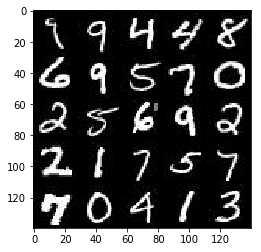

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

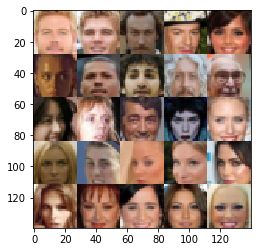

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # input: 28x28xchannels
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logit = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logit)

        return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        fc1 = tf.layers.dense(z, 7*7*512)
        proj1 = tf.reshape(fc1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(proj1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
#         deconv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
#         bn2 = tf.layers.batch_normalization(deconv2, training=is_train)
#         relu2 = tf.maximum(alpha * bn2, bn2)
#         # 7x7x256
        
        deconv3 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(deconv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, out_channel_dim)
    d_output_real, d_logit_real = discriminator(input_real)
    d_output_fake, d_logit_fake = discriminator(input_gen, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_output_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_output_fake)))

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    [_, image_width, image_height, image_channels] = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 

    print_every = 10
    show_every = 100
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_z: batch_z})
                
                report_images = batch_images
                report_z = batch_z

                if i % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if i % show_every == 0:
                    show_generator_output(sess, 4, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2	 Discriminator Loss: 0.8812	 Generator Loss: 0.8911
Epoch 1/2	 Discriminator Loss: 0.9537	 Generator Loss: 1.0259
Epoch 1/2	 Discriminator Loss: 0.9304	 Generator Loss: 0.7642
Epoch 1/2	 Discriminator Loss: 0.7051	 Generator Loss: 1.1368
Epoch 1/2	 Discriminator Loss: 1.5154	 Generator Loss: 4.0048
Epoch 1/2	 Discriminator Loss: 0.9305	 Generator Loss: 2.2267
Epoch 1/2	 Discriminator Loss: 0.6915	 Generator Loss: 1.5926
Epoch 1/2	 Discriminator Loss: 0.8848	 Generator Loss: 0.7111
Epoch 1/2	 Discriminator Loss: 0.8823	 Generator Loss: 0.7206
Epoch 1/2	 Discriminator Loss: 0.6345	 Generator Loss: 1.0565


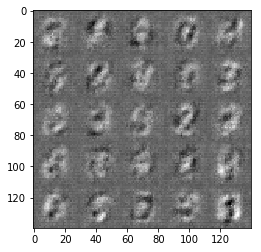

Epoch 1/2	 Discriminator Loss: 0.6344	 Generator Loss: 2.5404
Epoch 1/2	 Discriminator Loss: 0.4907	 Generator Loss: 1.5873
Epoch 1/2	 Discriminator Loss: 1.8228	 Generator Loss: 0.2157
Epoch 1/2	 Discriminator Loss: 0.5017	 Generator Loss: 1.2425
Epoch 1/2	 Discriminator Loss: 0.7276	 Generator Loss: 0.7656
Epoch 1/2	 Discriminator Loss: 0.3641	 Generator Loss: 1.7838
Epoch 1/2	 Discriminator Loss: 0.3450	 Generator Loss: 2.8841
Epoch 1/2	 Discriminator Loss: 0.2990	 Generator Loss: 2.3235
Epoch 1/2	 Discriminator Loss: 0.2470	 Generator Loss: 2.1859
Epoch 1/2	 Discriminator Loss: 0.2553	 Generator Loss: 1.9877


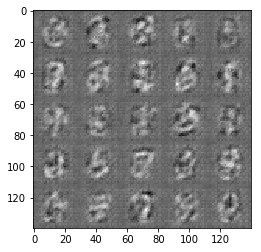

Epoch 1/2	 Discriminator Loss: 0.2361	 Generator Loss: 2.2648
Epoch 1/2	 Discriminator Loss: 0.2861	 Generator Loss: 1.7600
Epoch 1/2	 Discriminator Loss: 0.2225	 Generator Loss: 2.3310
Epoch 1/2	 Discriminator Loss: 0.2812	 Generator Loss: 1.7903
Epoch 1/2	 Discriminator Loss: 0.2198	 Generator Loss: 2.3869
Epoch 1/2	 Discriminator Loss: 0.3459	 Generator Loss: 1.8060
Epoch 1/2	 Discriminator Loss: 0.4407	 Generator Loss: 3.5322
Epoch 1/2	 Discriminator Loss: 0.2004	 Generator Loss: 2.3615
Epoch 1/2	 Discriminator Loss: 0.2188	 Generator Loss: 2.7737
Epoch 1/2	 Discriminator Loss: 0.2465	 Generator Loss: 2.3158


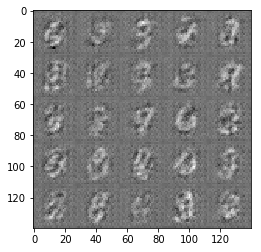

Epoch 1/2	 Discriminator Loss: 0.3011	 Generator Loss: 3.2775
Epoch 1/2	 Discriminator Loss: 0.2182	 Generator Loss: 2.2897
Epoch 1/2	 Discriminator Loss: 0.1904	 Generator Loss: 2.5961
Epoch 1/2	 Discriminator Loss: 0.2263	 Generator Loss: 2.1342
Epoch 1/2	 Discriminator Loss: 1.5048	 Generator Loss: 0.3186
Epoch 1/2	 Discriminator Loss: 0.1819	 Generator Loss: 2.7076
Epoch 1/2	 Discriminator Loss: 0.2782	 Generator Loss: 1.8346
Epoch 1/2	 Discriminator Loss: 0.1810	 Generator Loss: 2.6680
Epoch 1/2	 Discriminator Loss: 0.1291	 Generator Loss: 2.9445
Epoch 1/2	 Discriminator Loss: 0.1926	 Generator Loss: 2.5194


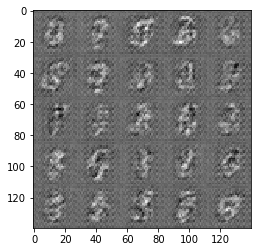

Epoch 1/2	 Discriminator Loss: 0.2505	 Generator Loss: 1.8988
Epoch 1/2	 Discriminator Loss: 0.1466	 Generator Loss: 2.9787
Epoch 1/2	 Discriminator Loss: 0.1501	 Generator Loss: 2.6346
Epoch 1/2	 Discriminator Loss: 0.1732	 Generator Loss: 2.4840
Epoch 1/2	 Discriminator Loss: 0.1336	 Generator Loss: 2.9032
Epoch 1/2	 Discriminator Loss: 0.1646	 Generator Loss: 2.5015
Epoch 2/2	 Discriminator Loss: 0.1189	 Generator Loss: 3.1173
Epoch 2/2	 Discriminator Loss: 0.1268	 Generator Loss: 2.7618
Epoch 2/2	 Discriminator Loss: 0.1107	 Generator Loss: 2.9090
Epoch 2/2	 Discriminator Loss: 0.1412	 Generator Loss: 2.5234


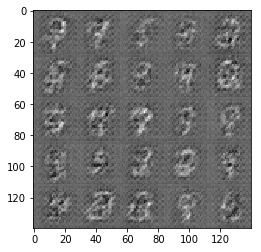

Epoch 2/2	 Discriminator Loss: 0.1186	 Generator Loss: 3.4773
Epoch 2/2	 Discriminator Loss: 0.1454	 Generator Loss: 3.6191
Epoch 2/2	 Discriminator Loss: 0.1405	 Generator Loss: 2.6394
Epoch 2/2	 Discriminator Loss: 0.1171	 Generator Loss: 3.1663
Epoch 2/2	 Discriminator Loss: 0.1172	 Generator Loss: 3.5935
Epoch 2/2	 Discriminator Loss: 0.1101	 Generator Loss: 3.0813
Epoch 2/2	 Discriminator Loss: 0.1230	 Generator Loss: 3.2245
Epoch 2/2	 Discriminator Loss: 0.3563	 Generator Loss: 1.8535
Epoch 2/2	 Discriminator Loss: 0.2291	 Generator Loss: 2.3310
Epoch 2/2	 Discriminator Loss: 0.1816	 Generator Loss: 2.5385


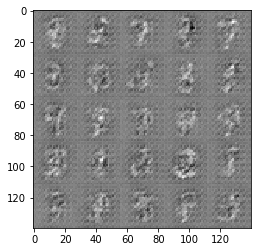

Epoch 2/2	 Discriminator Loss: 0.1200	 Generator Loss: 2.9368
Epoch 2/2	 Discriminator Loss: 0.1426	 Generator Loss: 2.7460
Epoch 2/2	 Discriminator Loss: 0.1246	 Generator Loss: 2.9256
Epoch 2/2	 Discriminator Loss: 0.1069	 Generator Loss: 3.0466
Epoch 2/2	 Discriminator Loss: 0.1274	 Generator Loss: 2.7530
Epoch 2/2	 Discriminator Loss: 0.1019	 Generator Loss: 3.1232
Epoch 2/2	 Discriminator Loss: 0.1116	 Generator Loss: 2.9570
Epoch 2/2	 Discriminator Loss: 0.0808	 Generator Loss: 3.5089
Epoch 2/2	 Discriminator Loss: 0.0911	 Generator Loss: 3.3062
Epoch 2/2	 Discriminator Loss: 0.0891	 Generator Loss: 3.2699


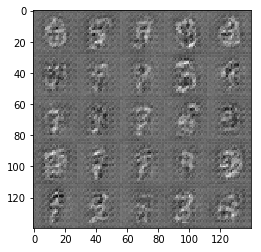

Epoch 2/2	 Discriminator Loss: 0.0843	 Generator Loss: 3.7729
Epoch 2/2	 Discriminator Loss: 0.0820	 Generator Loss: 3.2421
Epoch 2/2	 Discriminator Loss: 0.0578	 Generator Loss: 3.8482
Epoch 2/2	 Discriminator Loss: 0.0896	 Generator Loss: 3.1002
Epoch 2/2	 Discriminator Loss: 0.0610	 Generator Loss: 3.8685
Epoch 2/2	 Discriminator Loss: 0.0688	 Generator Loss: 3.6098
Epoch 2/2	 Discriminator Loss: 0.0795	 Generator Loss: 3.3261
Epoch 2/2	 Discriminator Loss: 0.1140	 Generator Loss: 2.7784
Epoch 2/2	 Discriminator Loss: 0.0786	 Generator Loss: 3.2533
Epoch 2/2	 Discriminator Loss: 0.0656	 Generator Loss: 3.5726


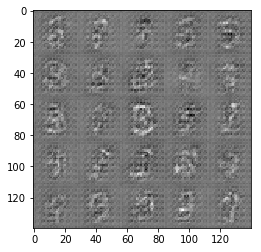

Epoch 2/2	 Discriminator Loss: 0.0929	 Generator Loss: 3.1593
Epoch 2/2	 Discriminator Loss: 0.0661	 Generator Loss: 3.3497
Epoch 2/2	 Discriminator Loss: 0.1190	 Generator Loss: 2.7002
Epoch 2/2	 Discriminator Loss: 0.0603	 Generator Loss: 3.8986
Epoch 2/2	 Discriminator Loss: 0.1069	 Generator Loss: 2.7464
Epoch 2/2	 Discriminator Loss: 0.0983	 Generator Loss: 3.1153
Epoch 2/2	 Discriminator Loss: 0.0763	 Generator Loss: 3.5137
Epoch 2/2	 Discriminator Loss: 0.1017	 Generator Loss: 3.4339
Epoch 2/2	 Discriminator Loss: 0.0864	 Generator Loss: 3.5312
Epoch 2/2	 Discriminator Loss: 0.1145	 Generator Loss: 2.7888


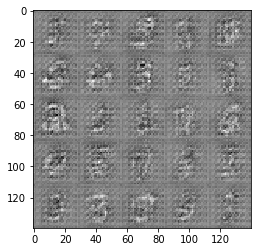

Epoch 2/2	 Discriminator Loss: 0.0679	 Generator Loss: 3.3968
Epoch 2/2	 Discriminator Loss: 0.0555	 Generator Loss: 3.9628
Epoch 2/2	 Discriminator Loss: 0.4059	 Generator Loss: 1.3644


IndexError: list index out of range

In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1	 Discriminator Loss: 0.7273	 Generator Loss: 1.0621
Epoch 1/1	 Discriminator Loss: 0.5805	 Generator Loss: 1.4008
Epoch 1/1	 Discriminator Loss: 0.4003	 Generator Loss: 1.6806
Epoch 1/1	 Discriminator Loss: 0.3311	 Generator Loss: 1.7677
Epoch 1/1	 Discriminator Loss: 0.3171	 Generator Loss: 1.9782
Epoch 1/1	 Discriminator Loss: 0.8489	 Generator Loss: 0.7195
Epoch 1/1	 Discriminator Loss: 0.7880	 Generator Loss: 0.8116
Epoch 1/1	 Discriminator Loss: 0.7064	 Generator Loss: 2.3377
Epoch 1/1	 Discriminator Loss: 0.6392	 Generator Loss: 1.1000
Epoch 1/1	 Discriminator Loss: 0.3840	 Generator Loss: 1.8384


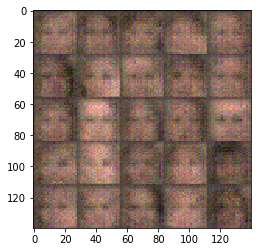

Epoch 1/1	 Discriminator Loss: 0.4256	 Generator Loss: 2.6107
Epoch 1/1	 Discriminator Loss: 0.3630	 Generator Loss: 1.6993
Epoch 1/1	 Discriminator Loss: 1.1138	 Generator Loss: 0.5594
Epoch 1/1	 Discriminator Loss: 0.5606	 Generator Loss: 1.5496
Epoch 1/1	 Discriminator Loss: 2.2791	 Generator Loss: 4.3574
Epoch 1/1	 Discriminator Loss: 0.6166	 Generator Loss: 1.5051
Epoch 1/1	 Discriminator Loss: 1.7255	 Generator Loss: 0.2767
Epoch 1/1	 Discriminator Loss: 0.9077	 Generator Loss: 1.0249
Epoch 1/1	 Discriminator Loss: 1.3233	 Generator Loss: 0.4504
Epoch 1/1	 Discriminator Loss: 0.3003	 Generator Loss: 2.7116


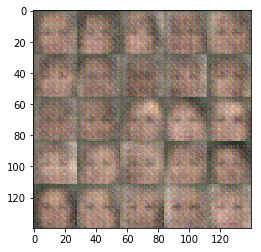

Epoch 1/1	 Discriminator Loss: 1.5100	 Generator Loss: 0.3579
Epoch 1/1	 Discriminator Loss: 0.6616	 Generator Loss: 1.8356
Epoch 1/1	 Discriminator Loss: 0.2830	 Generator Loss: 2.1878
Epoch 1/1	 Discriminator Loss: 0.5840	 Generator Loss: 1.3761
Epoch 1/1	 Discriminator Loss: 0.5397	 Generator Loss: 1.1478
Epoch 1/1	 Discriminator Loss: 0.6333	 Generator Loss: 1.5729
Epoch 1/1	 Discriminator Loss: 0.6382	 Generator Loss: 1.1157
Epoch 1/1	 Discriminator Loss: 0.4674	 Generator Loss: 2.5090
Epoch 1/1	 Discriminator Loss: 0.7055	 Generator Loss: 1.6871
Epoch 1/1	 Discriminator Loss: 0.9077	 Generator Loss: 0.7058


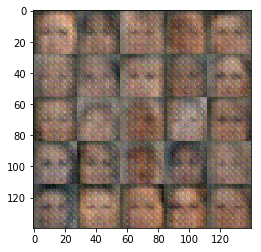

Epoch 1/1	 Discriminator Loss: 0.6906	 Generator Loss: 0.9970
Epoch 1/1	 Discriminator Loss: 1.0024	 Generator Loss: 0.6733
Epoch 1/1	 Discriminator Loss: 0.4780	 Generator Loss: 1.8550
Epoch 1/1	 Discriminator Loss: 0.4143	 Generator Loss: 1.4543
Epoch 1/1	 Discriminator Loss: 0.7440	 Generator Loss: 1.0730
Epoch 1/1	 Discriminator Loss: 0.4691	 Generator Loss: 1.4823
Epoch 1/1	 Discriminator Loss: 0.3959	 Generator Loss: 1.8665
Epoch 1/1	 Discriminator Loss: 0.3064	 Generator Loss: 1.7947
Epoch 1/1	 Discriminator Loss: 1.3366	 Generator Loss: 3.3396
Epoch 1/1	 Discriminator Loss: 0.4307	 Generator Loss: 2.1584


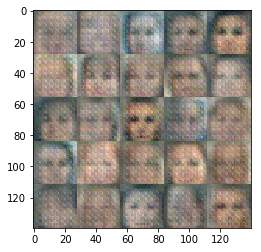

Epoch 1/1	 Discriminator Loss: 0.5884	 Generator Loss: 1.8320
Epoch 1/1	 Discriminator Loss: 0.6601	 Generator Loss: 1.0905
Epoch 1/1	 Discriminator Loss: 0.2632	 Generator Loss: 2.9411
Epoch 1/1	 Discriminator Loss: 0.3856	 Generator Loss: 1.5630
Epoch 1/1	 Discriminator Loss: 0.1604	 Generator Loss: 2.8572
Epoch 1/1	 Discriminator Loss: 0.7304	 Generator Loss: 4.2178
Epoch 1/1	 Discriminator Loss: 0.5136	 Generator Loss: 3.0150
Epoch 1/1	 Discriminator Loss: 0.4342	 Generator Loss: 1.5131
Epoch 1/1	 Discriminator Loss: 0.4231	 Generator Loss: 3.3881
Epoch 1/1	 Discriminator Loss: 0.1244	 Generator Loss: 3.9243


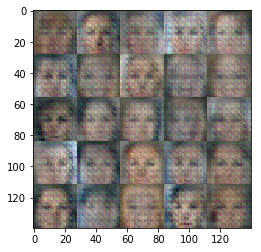

Epoch 1/1	 Discriminator Loss: 0.2187	 Generator Loss: 2.2654
Epoch 1/1	 Discriminator Loss: 0.6449	 Generator Loss: 0.9610
Epoch 1/1	 Discriminator Loss: 1.2957	 Generator Loss: 0.3912
Epoch 1/1	 Discriminator Loss: 0.8720	 Generator Loss: 0.7337
Epoch 1/1	 Discriminator Loss: 2.0626	 Generator Loss: 0.1960
Epoch 1/1	 Discriminator Loss: 0.2376	 Generator Loss: 2.6203
Epoch 1/1	 Discriminator Loss: 1.6011	 Generator Loss: 0.3277
Epoch 1/1	 Discriminator Loss: 0.3839	 Generator Loss: 1.7554
Epoch 1/1	 Discriminator Loss: 0.4980	 Generator Loss: 1.4160
Epoch 1/1	 Discriminator Loss: 0.6644	 Generator Loss: 0.9085


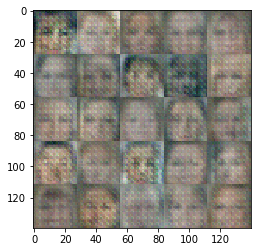

Epoch 1/1	 Discriminator Loss: 1.1240	 Generator Loss: 8.1188
Epoch 1/1	 Discriminator Loss: 0.5785	 Generator Loss: 6.2039
Epoch 1/1	 Discriminator Loss: 0.2408	 Generator Loss: 2.2518
Epoch 1/1	 Discriminator Loss: 0.3431	 Generator Loss: 2.8596
Epoch 1/1	 Discriminator Loss: 0.1097	 Generator Loss: 5.0932
Epoch 1/1	 Discriminator Loss: 0.2094	 Generator Loss: 4.5870
Epoch 1/1	 Discriminator Loss: 0.2391	 Generator Loss: 4.5771
Epoch 1/1	 Discriminator Loss: 0.1131	 Generator Loss: 5.7113
Epoch 1/1	 Discriminator Loss: 0.3890	 Generator Loss: 6.2396
Epoch 1/1	 Discriminator Loss: 0.2888	 Generator Loss: 3.6983


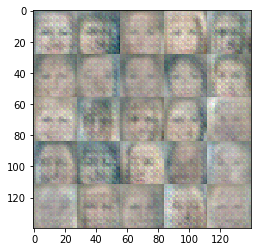

Epoch 1/1	 Discriminator Loss: 0.1350	 Generator Loss: 5.0268
Epoch 1/1	 Discriminator Loss: 0.1776	 Generator Loss: 7.4154
Epoch 1/1	 Discriminator Loss: 1.7279	 Generator Loss: 0.2803
Epoch 1/1	 Discriminator Loss: 0.1889	 Generator Loss: 2.8078
Epoch 1/1	 Discriminator Loss: 0.1078	 Generator Loss: 3.2524
Epoch 1/1	 Discriminator Loss: 0.2582	 Generator Loss: 5.0669
Epoch 1/1	 Discriminator Loss: 0.0812	 Generator Loss: 6.1444
Epoch 1/1	 Discriminator Loss: 0.1919	 Generator Loss: 3.9300
Epoch 1/1	 Discriminator Loss: 0.2330	 Generator Loss: 2.2085
Epoch 1/1	 Discriminator Loss: 0.1227	 Generator Loss: 3.4295


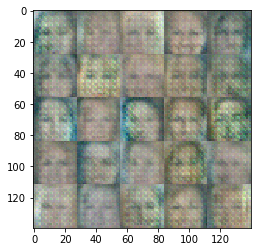

Epoch 1/1	 Discriminator Loss: 0.0612	 Generator Loss: 8.1379
Epoch 1/1	 Discriminator Loss: 0.0775	 Generator Loss: 7.4259
Epoch 1/1	 Discriminator Loss: 1.2826	 Generator Loss: 0.4174
Epoch 1/1	 Discriminator Loss: 0.5080	 Generator Loss: 1.2142
Epoch 1/1	 Discriminator Loss: 0.1392	 Generator Loss: 5.8579
Epoch 1/1	 Discriminator Loss: 0.0927	 Generator Loss: 4.2671
Epoch 1/1	 Discriminator Loss: 0.7830	 Generator Loss: 0.8199
Epoch 1/1	 Discriminator Loss: 0.2393	 Generator Loss: 1.9577
Epoch 1/1	 Discriminator Loss: 0.0663	 Generator Loss: 3.8548
Epoch 1/1	 Discriminator Loss: 0.7210	 Generator Loss: 6.9616


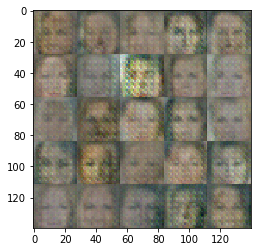

Epoch 1/1	 Discriminator Loss: 0.8434	 Generator Loss: 4.6712
Epoch 1/1	 Discriminator Loss: 0.1125	 Generator Loss: 4.1466
Epoch 1/1	 Discriminator Loss: 0.0690	 Generator Loss: 4.9681
Epoch 1/1	 Discriminator Loss: 0.0942	 Generator Loss: 3.4705
Epoch 1/1	 Discriminator Loss: 0.1362	 Generator Loss: 2.4608
Epoch 1/1	 Discriminator Loss: 0.4332	 Generator Loss: 1.2775
Epoch 1/1	 Discriminator Loss: 1.6250	 Generator Loss: 3.9747
Epoch 1/1	 Discriminator Loss: 0.2289	 Generator Loss: 2.0066
Epoch 1/1	 Discriminator Loss: 0.1942	 Generator Loss: 5.2017
Epoch 1/1	 Discriminator Loss: 0.2051	 Generator Loss: 4.6319


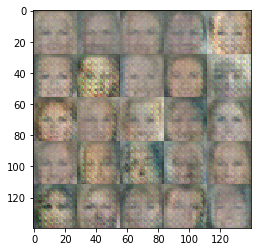

Epoch 1/1	 Discriminator Loss: 0.1255	 Generator Loss: 5.4535
Epoch 1/1	 Discriminator Loss: 0.0482	 Generator Loss: 4.3515
Epoch 1/1	 Discriminator Loss: 0.4140	 Generator Loss: 1.3144
Epoch 1/1	 Discriminator Loss: 0.0869	 Generator Loss: 3.1371
Epoch 1/1	 Discriminator Loss: 0.0702	 Generator Loss: 6.1917
Epoch 1/1	 Discriminator Loss: 0.0978	 Generator Loss: 3.3226
Epoch 1/1	 Discriminator Loss: 0.0362	 Generator Loss: 5.0840
Epoch 1/1	 Discriminator Loss: 0.0198	 Generator Loss: 8.1950
Epoch 1/1	 Discriminator Loss: 0.0871	 Generator Loss: 4.8869
Epoch 1/1	 Discriminator Loss: 0.1157	 Generator Loss: 4.5001


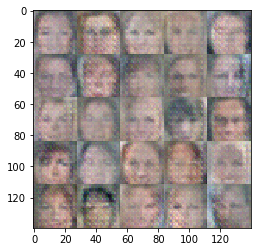

Epoch 1/1	 Discriminator Loss: 0.1096	 Generator Loss: 5.7053
Epoch 1/1	 Discriminator Loss: 0.0481	 Generator Loss: 4.2249
Epoch 1/1	 Discriminator Loss: 0.5072	 Generator Loss: 1.1418
Epoch 1/1	 Discriminator Loss: 2.1802	 Generator Loss: 0.1473
Epoch 1/1	 Discriminator Loss: 0.5676	 Generator Loss: 6.9184
Epoch 1/1	 Discriminator Loss: 1.0075	 Generator Loss: 10.7580
Epoch 1/1	 Discriminator Loss: 0.0909	 Generator Loss: 3.2219
Epoch 1/1	 Discriminator Loss: 1.1032	 Generator Loss: 3.3245
Epoch 1/1	 Discriminator Loss: 0.0685	 Generator Loss: 5.0325
Epoch 1/1	 Discriminator Loss: 0.7144	 Generator Loss: 0.8022


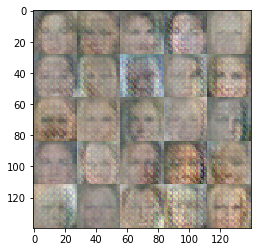

Epoch 1/1	 Discriminator Loss: 0.0746	 Generator Loss: 10.7968
Epoch 1/1	 Discriminator Loss: 0.8488	 Generator Loss: 6.1435
Epoch 1/1	 Discriminator Loss: 0.0825	 Generator Loss: 9.0523
Epoch 1/1	 Discriminator Loss: 0.0377	 Generator Loss: 5.8614
Epoch 1/1	 Discriminator Loss: 0.3575	 Generator Loss: 8.0193
Epoch 1/1	 Discriminator Loss: 0.0482	 Generator Loss: 6.4257
Epoch 1/1	 Discriminator Loss: 0.7175	 Generator Loss: 0.7893
Epoch 1/1	 Discriminator Loss: 0.1509	 Generator Loss: 3.1668
Epoch 1/1	 Discriminator Loss: 0.0462	 Generator Loss: 5.3942
Epoch 1/1	 Discriminator Loss: 0.0514	 Generator Loss: 5.3758


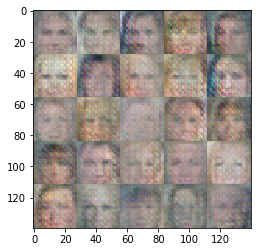

Epoch 1/1	 Discriminator Loss: 0.2823	 Generator Loss: 1.9520
Epoch 1/1	 Discriminator Loss: 0.0852	 Generator Loss: 7.2390
Epoch 1/1	 Discriminator Loss: 0.0607	 Generator Loss: 3.5515
Epoch 1/1	 Discriminator Loss: 0.0678	 Generator Loss: 15.8629
Epoch 1/1	 Discriminator Loss: 0.0234	 Generator Loss: 10.6019
Epoch 1/1	 Discriminator Loss: 0.0337	 Generator Loss: 11.4885
Epoch 1/1	 Discriminator Loss: 0.4782	 Generator Loss: 1.1913
Epoch 1/1	 Discriminator Loss: 0.2767	 Generator Loss: 1.8658
Epoch 1/1	 Discriminator Loss: 0.3183	 Generator Loss: 10.2693
Epoch 1/1	 Discriminator Loss: 1.9445	 Generator Loss: 0.1851


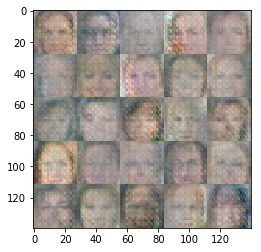

Epoch 1/1	 Discriminator Loss: 0.0129	 Generator Loss: 8.9748
Epoch 1/1	 Discriminator Loss: 0.2178	 Generator Loss: 4.1941
Epoch 1/1	 Discriminator Loss: 0.0390	 Generator Loss: 4.1792
Epoch 1/1	 Discriminator Loss: 0.0241	 Generator Loss: 10.6001
Epoch 1/1	 Discriminator Loss: 0.1323	 Generator Loss: 2.9851
Epoch 1/1	 Discriminator Loss: 0.2600	 Generator Loss: 8.2212
Epoch 1/1	 Discriminator Loss: 0.6323	 Generator Loss: 2.7044
Epoch 1/1	 Discriminator Loss: 0.2811	 Generator Loss: 1.6362
Epoch 1/1	 Discriminator Loss: 0.2808	 Generator Loss: 1.6774
Epoch 1/1	 Discriminator Loss: 0.1926	 Generator Loss: 6.2046


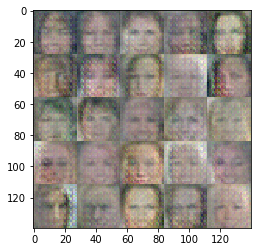

Epoch 1/1	 Discriminator Loss: 0.0138	 Generator Loss: 14.2936
Epoch 1/1	 Discriminator Loss: 0.1581	 Generator Loss: 4.9425
Epoch 1/1	 Discriminator Loss: 0.0453	 Generator Loss: 13.4717
Epoch 1/1	 Discriminator Loss: 0.0489	 Generator Loss: 9.7662
Epoch 1/1	 Discriminator Loss: 0.5189	 Generator Loss: 9.9903
Epoch 1/1	 Discriminator Loss: 0.0480	 Generator Loss: 9.3230
Epoch 1/1	 Discriminator Loss: 0.5714	 Generator Loss: 1.0949
Epoch 1/1	 Discriminator Loss: 0.0217	 Generator Loss: 5.7460


In [52]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.